# Business Understanding
## Background and Context

Digital platforms rely heavily on user-generated reviews to shape public perception, guide product improvements, and influence customer acquisition. For telecommunications and fintech platforms such as Safaricom and M-Pesa app store reviews play a critical role in:

- Assessing customer satisfaction
- Identifying service failures
- Informing feature updates
- Influencing app store ratings and discoverability

Kenya has one of the highest mobile penetration rates in Africa, and M-Pesa is among the continent’s most widely used mobile financial services platforms. As a result, these platforms receive thousands of reviews across multiple languages, including English, Swahili, and informal urban slang such as Sheng. Many reviews are code-mixed, combining elements of multiple languages within the same text.

While these reviews provide valuable business intelligence, their reliability is not guaranteed.

# Problem Statement
The increasing volume of multilingual user reviews introduces the risk of manipulated, spam-generated, coordinated, or otherwise inauthentic content. Suspicious reviews can:
- Artificially inflate or deflate app ratings
- Mislead product teams
- Distort sentiment analysis outputs
- Reduce trust in customer feedback systems
Currently, there is no localized, multilingual review authenticity detection framework specifically designed for Kenyan digital platforms that can process English, Swahili, and Sheng-like content.

# Core Business Problem
Safaricom currently lacks a multilingual, automated system capable of detecting suspicious or potentially fake reviews in English, Swahili and Sheng-like text, leading to reduced reliability of user feedback and potential distortion of product and reputation insights.

# Business Objectives
The primary objective of this project is to design and evaluate a machine learning-based system capable of identifying suspicious reviews in multilingual Safaricom and M-Pesa datasets.

1. To design a multilingual NLP framework for processing Safaricom and M-Pesa reviews in English, Swahili, and Sheng-like language.

2. To develop heuristic-based weak labeling and feature engineering techniques for identifying suspicious review behavior.

3. To build and evaluate a baseline machine learning model for fake review detection and demonstrate its practical applicability.

In [114]:
import pandas as pd
import numpy as np
import re
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, classification_report, 
accuracy_score, precision_recall_curve, roc_auc_score, average_precision_score)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')


# 1. Data Cleaning
### Load and inspect the dataset

In [115]:
df = pd.read_csv("./Data/safaricom_reviews_multilingual.csv")
print("Shape:", df.shape)
print("\nColumns:")
print(df.columns)

print("\nFirst 5 rows:")
df.head()

Shape: (32000, 12)

Columns:
Index(['app_name', 'app_id', 'reviewId', 'userName', 'review_text', 'rating',
       'date', 'thumbs_up', 'version', 'lang_detected', 'is_code_mixed',
       'is_sheng_like'],
      dtype='object')

First 5 rows:


,app_name,app_id,reviewId,userName,review_text,rating,date,thumbs_up,version,lang_detected,is_code_mixed,is_sheng_like
0,M-PESA,com.safaricom.mpesa.lifestyle,f6df29d5-b57d-4324-be85-89abeaa3447a,cynthia wairimu,best,5,2026-02-11 23:31:13,0,3.5.9,unknown,False,False
1,M-PESA,com.safaricom.mpesa.lifestyle,d5067a38-f2c0-4e3d-b1c7-9e84a59adc4a,Chepchir Adhis,😔,1,2026-02-11 23:05:42,0,NaN,unknown,False,False
2,M-PESA,com.safaricom.mpesa.lifestyle,68a05147-4b49-4eb2-85c3-5d081bd0ae1b,Charles Muchiri,Better option this vantine. 18yrs old day to d...,5,2026-02-11 22:33:17,0,3.5.9,en,False,False
3,M-PESA,com.safaricom.mpesa.lifestyle,b75a78c7-ae4b-4cf8-9a4c-108f9bb9498f,GODFREY ODINGA,Amazing,5,2026-02-11 21:38:06,0,3.5.9,unknown,False,False
4,M-PESA,com.safaricom.mpesa.lifestyle,c962c8a9-6041-46e9-8325-49b699e6f645,Joy Chepkemboi,Its so easy to use at your comfort and you don...,1,2026-02-11 21:35:03,0,3.5.9,en,False,False


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   app_name       32000 non-null  object
 1   app_id         32000 non-null  object
 2   reviewId       32000 non-null  object
 3   userName       32000 non-null  object
 4   review_text    32000 non-null  object
 5   rating         32000 non-null  int64 
 6   date           32000 non-null  object
 7   thumbs_up      32000 non-null  int64 
 8   version        28741 non-null  object
 9   lang_detected  32000 non-null  object
 10  is_code_mixed  32000 non-null  bool  
 11  is_sheng_like  32000 non-null  bool  
dtypes: bool(2), int64(2), object(8)
memory usage: 2.5+ MB


## 2. Data Cleaning and Preprocessing
### Goals 
1. Handle missing values
2. Check for duplicated 
3. Clean review_text (remove URLs/noise, keep emojis + Sheng slang)
4. Convert date → datetime
5. Create robust text representations for:
    - modeling (text_clean)
    - duplicates (text_norm)

In [117]:
# Null values
df.isnull().sum().sort_values(ascending=False)

version          3259
is_sheng_like       0
is_code_mixed       0
lang_detected       0
thumbs_up           0
date                0
rating              0
review_text         0
userName            0
reviewId            0
app_id              0
app_name            0
dtype: int64

In [118]:
#  fill Missing values version 
df["version"] = df["version"].fillna("unknown_version")

In [119]:
df.groupby(df['version'].isnull())['rating'].mean()

version
False    4.339812
Name: rating, dtype: float64

### Duplicate Analysis
Check for duplicates in the dataset

In [120]:
# Duplicated rows
df.duplicated().sum()

0

In [121]:
# Duplicates by revewID
df.duplicated(subset='reviewId').sum()

0

In [122]:
df.duplicated(subset='userName').sum()

1778

In [123]:
# Filter the dataframe for all duplicated user names
# Sort by userName so the duplicates appear together
duplicates_df = df[df.duplicated(subset='userName', keep=False)].sort_values(by='userName')

# 3. View the first few rows
print(duplicates_df[['userName', 'review_text', 'rating', 'date']].tail(10))

               userName                                        review_text  \
11061      sylas letozy                                               best   
17839      sylas letozy  your services people are complaining currently...   
16420     victor lunale                                 Excellent to first   
2596      victor lunale                                       I Crown 👑 it   
23268  zigwazack zakayo                                              excel   
1867   zigwazack zakayo                      it's good to transact with it   
24844             ɪʙʀᴀʜ                 The app is really great.Love it❤❤❤   
3444              ɪʙʀᴀʜ                           Amazing transparent app🥰   
26838      عابدول ماجيد                                          Amazing 😄   
11425      عابدول ماجيد                                  Best ... reliable   

       rating                 date  
11061       5  2025-06-02 14:48:51  
17839       1  2025-09-19 18:17:56  
16420       5  2026-01-12 11:0

### Text cleaning
Standardizing the `review_text` column

In [124]:
# --- Text cleaning ---
def clean_text_keep_emojis(text: str) -> str:
    """
    Light cleaning:
    - remove URLs
    - remove control whitespace
    - normalize spaces
    - keep emojis + Sheng slang intact
    """
    if not isinstance(text, str):
        return ""
    t = text.strip()
    t = re.sub(r"http\S+|www\.\S+", " ", t)      # remove urls
    t = re.sub(r"[\r\n\t]+", " ", t)            # normalize whitespace
    t = re.sub(r"\s{2,}", " ", t)               # collapse spaces
    return t.strip() 

df["text_clean"] = df["review_text"].map(clean_text_keep_emojis)

# normalized form for duplication detection
df["text_norm"] = (
    df["text_clean"]
    .str.lower()
    .str.replace(r"\s+", " ", regex=True)
    .fillna("")
)

df[["review_text", "text_clean", "text_norm", "lang_detected", "is_code_mixed", "is_sheng_like"]].head(10)

,review_text,text_clean,text_norm,lang_detected,is_code_mixed,is_sheng_like
0,best,best,best,unknown,False,False
1,😔,😔,😔,unknown,False,False
2,Better option this vantine. 18yrs old day to d...,Better option this vantine. 18yrs old day to d...,better option this vantine. 18yrs old day to d...,en,False,False
3,Amazing,Amazing,amazing,unknown,False,False
4,Its so easy to use at your comfort and you don...,Its so easy to use at your comfort and you don...,its so easy to use at your comfort and you don...,en,False,False
5,good 👍,good 👍,good 👍,unknown,False,False
6,😊👍,😊👍,😊👍,unknown,False,False
7,very helpful and reduces a lot of work in term...,very helpful and reduces a lot of work in term...,very helpful and reduces a lot of work in term...,en,False,False
8,its good and nice app,its good and nice app,its good and nice app,en,False,False
9,Great,Great,great,unknown,False,False


### Text length 
Create columns for number or characters and text length
- Number of words in the text

In [125]:
df["char_length"] = df["text_norm"].str.len()


In [126]:
# column for character_length
df["char_length"] = df["text_norm"].str.len()

# word_count column
df['word_count'] = df['review_text'].fillna('').apply(lambda x: len(str(x).split()))

# top 5 longest reviews
top_5_longest = df.nlargest(5, 'word_count')
print(top_5_longest[['userName', 'word_count', 'review_text', 'rating']])

                 userName  word_count  \
30859       albanus kioko         140   
5656   Jeane Ng'eno-Tarus          96   
6291         new Begining          96   
7387           Jewel Hope          96   
19976       Kennedy Kamau          96   

                                             review_text  rating  
30859  Fa CJ HH cc H BB see bvase boo HH v saa nuke b...       2  
5656   I was looking for how to hide or remove the fu...       3  
6291   I'm trying to withdraw from PayPal but the app...       1  
7387   I have used this app for so long, and it has a...       1  
19976  I love the app i use it on a daily basis but a...       4  


In [127]:
# duplicated texts
df[df['text_clean'].duplicated(keep=False)]['text_norm'].value_counts().head(10)

good         2511
excellent     965
nice          593
best          527
great         440
perfect       351
good app      350
awesome       305
very good     300
nice app      296
Name: text_norm, dtype: int64

There is a large number of low information reviews that do not provide actionable feedback while inflating the reviews.

In [128]:
generic_pattern = re.compile(
    r"^(very\s+)?(good|nice|great|excellent|awesome|amazing|best)(\s+app)?(\s*👍)?$"
)

df["is_generic_positive_template"] = df["text_clean"].apply(
    lambda x: 1 if generic_pattern.match(x.strip()) else 0
)

In [129]:
df["is_generic_positive_template"].mean()

0.17896875

#### emoji count

In [130]:
emoji_pattern = re.compile(r"[\U00010000-\U0010ffff]", flags=re.UNICODE)
df["emoji_count"] = df["text_clean"].apply(lambda x: len(emoji_pattern.findall(x)))

#### Duplicate reviews

In [131]:
dup_counts = df["text_clean"].value_counts()
df["duplicate_count"] = df["text_clean"].map(dup_counts)
df.head()

,app_name,app_id,reviewId,userName,review_text,rating,date,thumbs_up,version,lang_detected,is_code_mixed,is_sheng_like,text_clean,text_norm,char_length,word_count,is_generic_positive_template,emoji_count,duplicate_count
0,M-PESA,com.safaricom.mpesa.lifestyle,f6df29d5-b57d-4324-be85-89abeaa3447a,cynthia wairimu,best,5,2026-02-11 23:31:13,0,3.5.9,unknown,False,False,best,best,4,1,1,0,421
1,M-PESA,com.safaricom.mpesa.lifestyle,d5067a38-f2c0-4e3d-b1c7-9e84a59adc4a,Chepchir Adhis,😔,1,2026-02-11 23:05:42,0,unknown_version,unknown,False,False,😔,😔,1,1,0,1,1
2,M-PESA,com.safaricom.mpesa.lifestyle,68a05147-4b49-4eb2-85c3-5d081bd0ae1b,Charles Muchiri,Better option this vantine. 18yrs old day to d...,5,2026-02-11 22:33:17,0,3.5.9,en,False,False,Better option this vantine. 18yrs old day to d...,better option this vantine. 18yrs old day to d...,56,10,0,0,1
3,M-PESA,com.safaricom.mpesa.lifestyle,b75a78c7-ae4b-4cf8-9a4c-108f9bb9498f,GODFREY ODINGA,Amazing,5,2026-02-11 21:38:06,0,3.5.9,unknown,False,False,Amazing,amazing,7,1,0,0,40
4,M-PESA,com.safaricom.mpesa.lifestyle,c962c8a9-6041-46e9-8325-49b699e6f645,Joy Chepkemboi,Its so easy to use at your comfort and you don...,1,2026-02-11 21:35:03,0,3.5.9,en,False,False,Its so easy to use at your comfort and you don...,its so easy to use at your comfort and you don...,91,19,0,0,1


### Timestamp processing
Converting date column from object to date time

In [132]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df['date'].min(), df['date'].max()

(Timestamp('2023-08-26 07:44:28'), Timestamp('2026-02-11 23:31:13'))

In [133]:
# The dates range from 2023-08 to 2026-02

In [134]:
df['lang_detected'].value_counts()


en         16683
unknown     7626
other       7527
sw           164
Name: lang_detected, dtype: int64

In [135]:
# Define common keywords for recovery
en_keywords = {'good', 'best', 'great', 'cool', 'excellent', 'nice', 'awesome', 'amazing', 'perfect', 'love', 'app', 'slow', 'fair', 'enough'}
sw_keywords = {'poa', 'safi', 'mzuri', 'mbaya', 'shida', 'asante', 'hakuna', 'wapi', 'fiti', 'vizuri'}

def refine_language(row):
    current = row['lang_detected']
    # If the text is short and labeled unknown/other, check keywords
    if current in ['unknown', 'other']:
        words = set(row['text_norm'].split())
        if words.intersection(en_keywords):
            return 'en'
        if words.intersection(sw_keywords):
            return 'sw'
    return current

df['lang_refined'] = df.apply(refine_language, axis=1)
df[["review_text", "text_norm", "lang_detected", "lang_refined"]].head(10)
print(df['lang_refined'].value_counts())

en         26799
other       2987
unknown     2020
sw           194
Name: lang_refined, dtype: int64


In [136]:
# Filtering the dataframe for 'unknown' refined language
unknown_reviews = df[df['lang_refined'] == 'unknown']

# Displaying the count and the first 20 rows of relevant columns
print(f"Total reviews still labeled 'unknown': {len(unknown_reviews)}")

# Using .head(20) to see a sample
unknown_reviews[['review_text', 'text_norm', 'rating', 'lang_detected', 'lang_refined']].head()

Total reviews still labeled 'unknown': 2020


,review_text,text_norm,rating,lang_detected,lang_refined
1,😔,😔,1,unknown,unknown
6,😊👍,😊👍,5,unknown,unknown
44,dope,dope,4,unknown,unknown
58,𝕖𝕒𝕤𝕪 𝕥𝕠 𝕒𝕔𝕔𝕖𝕤𝕤,𝕖𝕒𝕤𝕪 𝕥𝕠 𝕒𝕔𝕔𝕖𝕤𝕤,5,unknown,unknown
61,👍👍👍,👍👍👍,5,unknown,unknown


# 3. Exploratory Data Analysis (EDA)
Goals
1. Rating distribution
2. Language distribution
3. Review frequency over time
4. Term Frequency
5. Weak labelling
6. Sentiment rating Deception


### 3.1 Rating Distribution

In [137]:
rating_counts = df['rating'].value_counts().sort_index()
print(rating_counts)


1     2954
2      807
3     1632
4     3625
5    22982
Name: rating, dtype: int64


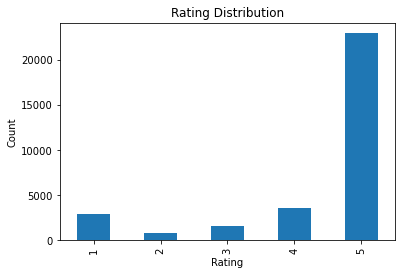

1     2954
2      807
3     1632
4     3625
5    22982
Name: rating, dtype: int64
Share of 5★: 0.7181875


In [138]:
# Bar graph for rating distribution
df["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

print(rating_counts)
print("Share of 5★:", (df["rating"] == 5).mean())

In [139]:
# The ratimg is skewed towards 5 stars where the 5 stars are dominant
# The dataset exhibits a heavily right-skewed rating distribution, with 71.8% of reviews being 5-stars.

### 3.2 Language distribution

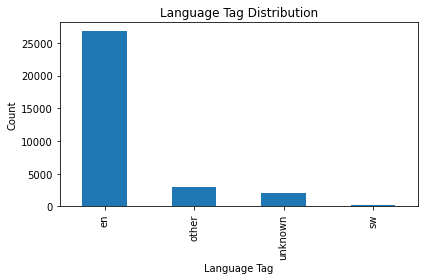

en         26799
other       2987
unknown     2020
sw           194
Name: lang_refined, dtype: int64
Code-mixed share: 0.0005
Sheng-like share: 0.0029375


In [140]:
# Plot of language distribution
lang_counts = df["lang_refined"].value_counts()

plt.figure()
lang_counts.plot(kind="bar")
plt.title("Language Tag Distribution")
plt.xlabel("Language Tag")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print(lang_counts)
print("Code-mixed share:", df["is_code_mixed"].mean())
print("Sheng-like share:", df["is_sheng_like"].mean())

### 3.3 Review word length distribution

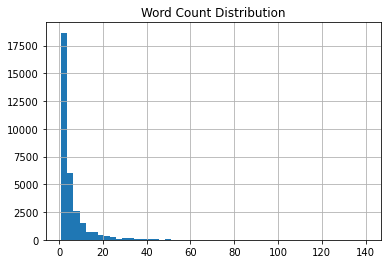

In [141]:
# Plot of word count distribution
df["word_count"].hist(bins=50)
plt.title("Word Count Distribution")
plt.show()

In [142]:
# There are many short reviews between 1-2 words with a skew towards short reviews

### 3.4 Burst Activity Visualization


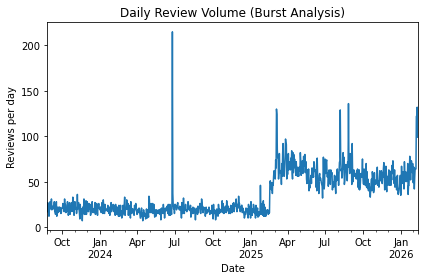

count    901.000000
mean      35.516093
std       23.011906
min        7.000000
25%       18.000000
50%       24.000000
75%       54.000000
max      215.000000
Name: n, dtype: float64
Top spike days:
 date
2024-06-25    215
2025-08-27    136
2026-02-10    132
2025-03-05    130
2025-08-07    129
Name: n, dtype: int64


In [143]:
#Plot of review frequency over time
daily = df.set_index("date").resample("D").size().rename("n")

plt.figure()
daily.plot()
plt.title("Daily Review Volume (Burst Analysis)")
plt.xlabel("Date")
plt.ylabel("Reviews per day")
plt.tight_layout()
plt.show()

print(daily.describe())
print("Top spike days:\n", daily.nlargest(5))

In [144]:
# One extreme outlier is observed, where daily reviews increased dramatically compared to surrounding periods. 
# Such anomalies indicate coordinated review behavior, product-related events, or automated posting activity.

Mark burst days using a percentile threshold

In [145]:
p97 = daily.quantile(0.97)   # top 3% days
burst_days = set(daily[daily >= p97].index.date)

df["is_burst_day"] = df["date"].dt.date.isin(burst_days)

print("Burst threshold (97th percentile):", p97)
print("Burst-day reviews:", df["is_burst_day"].sum())
print("Burst-day share:", df["is_burst_day"].mean())

Burst threshold (97th percentile): 78.0
Burst-day reviews: 2885
Burst-day share: 0.09015625


### 3.5 Term frequancy
 - Determine the frequent code mixed words
 - Determine frequent words combined

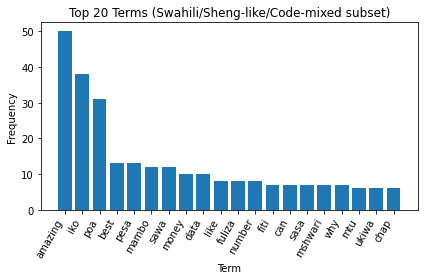

[('amazing', 50),
 ('iko', 38),
 ('poa', 31),
 ('best', 13),
 ('pesa', 13),
 ('mambo', 12),
 ('sawa', 12),
 ('money', 10),
 ('data', 10),
 ('like', 8),
 ('fuliza', 8),
 ('number', 8),
 ('fiti', 7),
 ('can', 7),
 ('sasa', 7),
 ('mshwari', 7),
 ('why', 7),
 ('mtu', 6),
 ('ukiwa', 6),
 ('chap', 6)]

In [146]:
stop_en = set("the a an and or is are was were to of in for on at it this that i you we they he she my our your app mpesa m-pesa safaricom".split())
stop_sw = set("na ya kwa ni si hii hiyo sana pia tu nilikuwa mimi wewe yeye sisi wao".split())

def top_terms(text_series, n=20):
    c = Counter()
    for t in text_series.dropna():
        words = re.findall(r"[a-zA-ZÀ-ÿ']+", t.lower())
        for w in words:
            if len(w) <= 2:
                continue
            if w in stop_en or w in stop_sw:
                continue
            c[w] += 1
    return c.most_common(n)

# focus on Swahili + Sheng-like + code-mixed buckets (more realistic than lang_refined alone)
subset = df[(df["lang_refined"] == "sw") | (df["is_sheng_like"] == True) | (df["is_code_mixed"] == True)]
top20 = top_terms(subset["text_clean"], n=20)

terms, freqs = zip(*top20) if top20 else ([], [])

plt.figure()
plt.bar(range(len(freqs)), freqs)
plt.xticks(range(len(terms)), terms, rotation=60, ha="right")
plt.title("Top 20 Terms (Swahili/Sheng-like/Code-mixed subset)")
plt.xlabel("Term")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

top20

#### Top frequent phrases

In [147]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1,2))
X = vectorizer.fit_transform(df["text_clean"])
print(vectorizer.get_feature_names())

['and', 'app', 'best', 'easy', 'excellent', 'for', 'good', 'great', 'is', 'it', 'nice', 'the', 'the app', 'the best', 'this', 'to', 'to use', 'use', 'very', 'you']


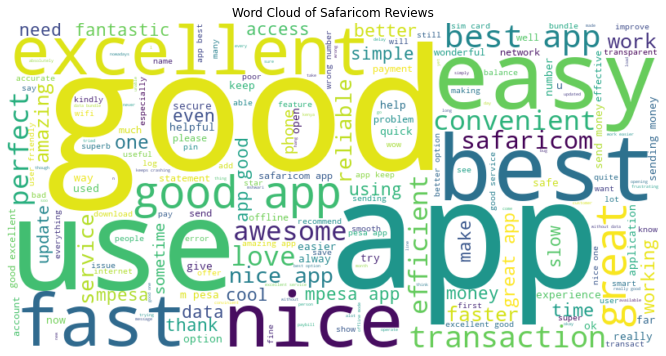

In [148]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(df["text_norm"])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200
).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Safaricom Reviews")
plt.show()

## 4. Heuristic Weak Labeling (is_suspicious)
### 4.1 Multilingual lexicon-based sentiment score (English + Swahili + Sheng + emojis)

In [149]:

# --- Existing lexicons (keep yours if already defined) ---
positive_en = set("good great best amazing awesome excellent love loved nice perfect works working helpful fast reliable".split())
negative_en = set("bad worst terrible hate hated slow bug bugs buggy crash crashes crashing error errors fail failed failing useless poor disappointed disappointing scam".split())

positive_sw = set(["nzuri", "safi", "bomba", "vizuri", "bora", "napenda"])
negative_sw = set(["mbaya", "mbovu", "kosa", "makosa", "tatizo", "matatizo", "inakwama", "haifanyi", "haiwezi"])

positive_sh = set(["poa", "noma", "fresh", "safi", "kali", "fiti"])
negative_sh = set(["mbaya", "mbovu", "imekwama", "imeshindwa", "imeniboo"])

pos_emojis = {"😀","😃","😄","😁","😍","😊","👍","❤️","❤","💯","🔥","🎉"}
neg_emojis = {"😡","😠","😤","😭","😢","👎","💔","😔","🤬"}

negation_words = {"not", "no", "never", "hakuna", "sio", "si", "ha"}

# --- Improved normalized sentiment ---
def sentiment_score_improved(text: str) -> float:
    if not isinstance(text, str):
        return 0.0

    t = text.lower()
    words = re.findall(r"[a-zA-ZÀ-ÿ']+", t)

    if len(words) == 0:
        return 0.0

    score = 0
    negate = False

    for w in words:
        if w in negation_words:
            negate = True
            continue

        val = 0
        if w in positive_en or w in positive_sw or w in positive_sh:
            val = 1
        elif w in negative_en or w in negative_sw or w in negative_sh:
            val = -1

        if negate:
            val = -val
            negate = False

        score += val

    # emoji sentiment
    for e in pos_emojis:
        if e in text:
            score += 1
    for e in neg_emojis:
        if e in text:
            score -= 1

    # normalize to [-1, 1] approximately
    return score / len(words)

# Apply sentiment
df["sent_score_norm"] = df["text_norm"].map(sentiment_score_improved)

# Scale rating to [-1, 1]
df["rating_scaled"] = (df["rating"] - 3) / 2

# Strong mismatch feature
df["rating_sentiment_mismatch"] = (
    df["rating_scaled"] - df["sent_score_norm"]
) ** 2

# Sentiment intensity (often strong signal)
df["abs_sentiment_strength"] = df["sent_score_norm"].abs()

print("Sentiment features created.")

Sentiment features created.


### 4.2 Sentiment–Rating Deception Rule

Contradiction examples
 - Rating ≤ 2 but sentiment score > 0
 - Rating ≥ 4 but sentiment score < 0

In [150]:
df["sentiment_rating_contradiction"] = (
    ((df["rating"] <= 2) & (df["sent_score_norm"] > 0)) |
    ((df["rating"] >= 4) & (df["sent_score_norm"] < 0))
)

print("Contradictions:", df["sentiment_rating_contradiction"].sum())
print("Contradiction rate:", df["sentiment_rating_contradiction"].mean())

Contradictions: 984
Contradiction rate: 0.03075


### 4.3 Combine contradiction + burst into is_suspicious

In [151]:
df["is_suspicious"] = (
    df["sentiment_rating_contradiction"] | df["is_burst_day"]
).astype(int)

print("Suspicious reviews:", df["is_suspicious"].sum())
print("Suspicious rate:", df["is_suspicious"].mean())

Suspicious reviews: 3787
Suspicious rate: 0.11834375


## 5) Behavioral Feature Engineering (Users + Duplicates + Burst Participation)
### 5.1 Duplicate detection (exact duplicates after normalization)

In [152]:
dup_counts = (
    df.groupby(["userName", "text_norm"])
      .size()
      .reset_index(name="n")
)

dup_texts = dup_counts[dup_counts["n"] > 1].copy()

# duplicate "excess": if a user posted same text n times, excess = (n - 1)
dup_texts["dup_excess"] = dup_texts["n"] - 1

dup_per_user = (
    dup_texts.groupby("userName")["dup_excess"]
             .sum()
             .reset_index()
)

dup_per_user.sort_values("dup_excess", ascending=False).head(10)

,userName,dup_excess
28,John Mwangi,3
39,Nicholas musungu Masanga,2
0,Alex Kamau,1
44,Peter Macharia,1
49,Richard Mutuku,1
48,Qadar Bakaari,1
47,Proud of Africa,1
46,Pretty Vall,1
45,Pius Orima,1
42,Patrick,1


### 5.2 Create a “suspicion score” per user and plot Top 10

,userName,reviews,suspicious,burst,thumbs_up,dup_excess,suspicious_rate,suspicion_score
12556,John Mwangi,12,3,1,4,3,0.250000,9.5
20405,Peter Mwangi,6,5,3,0,0,0.833333,6.5
3144,Brian,12,4,3,2,0,0.333333,5.5
28043,juhckujuhcku jahkanaan,2,2,2,0,1,1.000000,5.0
5403,David Kimani,5,3,3,0,0,0.600000,4.5
5427,David Maina,7,2,1,1,1,0.285714,4.5
5853,Dennis Mwangi,5,3,2,0,0,0.600000,4.0
18941,Nicholas musungu Masanga,3,0,0,0,2,0.000000,4.0
5892,Dennis Sang,3,1,1,0,1,0.333333,3.5
22125,Saibulu Sikoyo Sikoyo,2,1,1,0,1,0.500000,3.5


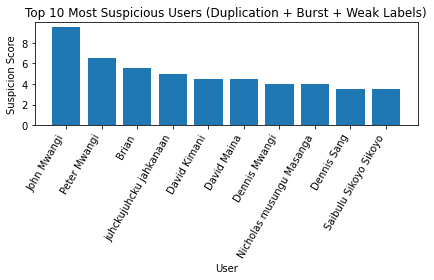

In [153]:
user_stats = (
    df.groupby("userName")
      .agg(
          reviews=("reviewId", "count"),
          suspicious=("is_suspicious", "sum"),
          burst=("is_burst_day", "sum"),
          thumbs_up=("thumbs_up", "sum"),
      )
      .reset_index()
)

user_stats = user_stats.merge(dup_per_user, on="userName", how="left")
user_stats["dup_excess"] = user_stats["dup_excess"].fillna(0).astype(int)

user_stats["suspicious_rate"] = user_stats["suspicious"] / user_stats["reviews"]

# simple explainable score (tune weights as needed)
user_stats["suspicion_score"] = (
    user_stats["suspicious"]
    + 2 * user_stats["dup_excess"]
    + 0.5 * user_stats["burst"]
)

top10_users = user_stats.sort_values("suspicion_score", ascending=False).head(10)
display(top10_users)

plt.figure()
plt.bar(top10_users["userName"], top10_users["suspicion_score"])
plt.xticks(rotation=60, ha="right")
plt.title("Top 10 Most Suspicious Users (Duplication + Burst + Weak Labels)")
plt.xlabel("User")
plt.ylabel("Suspicion Score")
plt.tight_layout()
plt.show()

### 5.3 Duplicate/repeated text

In [154]:
# per-user repeated normalized text count
tmp = df.groupby(["userName", "text_norm"]).size().reset_index(name="n")
tmp = tmp[tmp["n"] > 1].copy()
tmp["dup_excess"] = tmp["n"] - 1
dup_per_user = tmp.groupby("userName")["dup_excess"].sum().reset_index()

df = df.merge(dup_per_user, on="userName", how="left")
df["dup_excess"] = df["dup_excess"].fillna(0).astype(int)

# Mark if THIS review text is duplicated by same user
dup_text_pairs = set(zip(tmp["userName"], tmp["text_norm"]))
df["is_user_text_duplicated"] = list(zip(df["userName"], df["text_norm"]))
df["is_user_text_duplicated"] = df["is_user_text_duplicated"].apply(lambda x: 1 if x in dup_text_pairs else 0)


In [155]:
# You can tune this logic. Keep it explainable.
df["is_suspicious"] = (
    (df["sentiment_rating_contradiction"] == 1) |
    (df["is_burst_day"] == 1) |
    (df["is_user_text_duplicated"] == 1)
).astype(int)

print("Suspicious rate:", df["is_suspicious"].mean())
df[["text_norm","rating","lang_refined","is_code_mixed","is_sheng_like","is_suspicious"]].head()

Suspicious rate: 0.12240625


,text_norm,rating,lang_refined,is_code_mixed,is_sheng_like,is_suspicious
0,best,5,en,False,False,1
1,😔,1,unknown,False,False,1
2,better option this vantine. 18yrs old day to d...,5,en,False,False,1
3,amazing,5,en,False,False,1
4,its so easy to use at your comfort and you don...,1,en,False,False,1


In [156]:
def build_reason(row):
    reasons = []
    if int(row.get("sentiment_rating_contradiction", 0)) == 1:
        reasons.append("sentiment_rating_contradiction")
    if int(row.get("is_burst_day", 0)) == 1:
        reasons.append("burst_day")
    if int(row.get("is_user_text_duplicated", 0)) == 1:
        reasons.append("duplicate_text")
    return "|".join(reasons) if reasons else "none"

df["suspicion_reason"] = df.apply(build_reason, axis=1)
df["suspicion_reason"].value_counts().head(10)

none                                             28083
burst_day                                         2797
sentiment_rating_contradiction                     899
duplicate_text                                     130
sentiment_rating_contradiction|burst_day            82
burst_day|duplicate_text                             6
sentiment_rating_contradiction|duplicate_text        3
Name: suspicion_reason, dtype: int64

### Weak label preview


In [157]:
# Initial heuristic labeling produced an unrealistically high proportion of suspicious reviews
# The final weak supervision framework labeled approximately 24.7% o.f reviews as suspicious

## 6. Modelling
### 6.1 Baseline Model
If text strongly implies a different rating, that mismatch is a signal for deception or low-quality reviews.


In [158]:
# Split to train set and test set
X = df.copy()
y = df["is_suspicious"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [159]:
# baseline model instantiate
baseline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_df=0.9
    )),
    ("clf", LogisticRegression(
        max_iter=300,
        class_weight="balanced"   # important for imbalanced labels
    ))
])

# fit and predict
baseline.fit(X_train["text_clean"].fillna(""), y_train)
proba = baseline.predict_proba(X_test["text_clean"].fillna(""))[:, 1]
pred  = (proba >= 0.5).astype(int)

print("BASELINE REPORT (threshold=0.50)")
print(classification_report(y_test, pred, digits=3))

print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC :", average_precision_score(y_test, proba))

BASELINE REPORT (threshold=0.50)
              precision    recall  f1-score   support

           0      0.892     0.660     0.758      5617
           1      0.148     0.425     0.220       783

    accuracy                          0.631      6400
   macro avg      0.520     0.542     0.489      6400
weighted avg      0.801     0.631     0.692      6400

ROC-AUC: 0.5583453896456911
PR-AUC : 0.1854054995974873


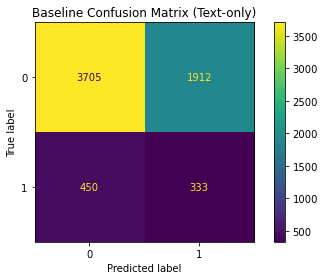

In [160]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp.plot(values_format="d")
plt.title("Baseline Confusion Matrix (Text-only)")
plt.tight_layout()
plt.show()

In [161]:
import numpy as np

# Review length
df["review_length"] = df["text_norm"].astype(str).str.len()

# Word count
df["word_count"] = df["text_norm"].astype(str).str.split().apply(len)

# Exclamation count
df["exclamation_count"] = df["text_norm"].astype(str).str.count("!")

# Uppercase ratio
df["uppercase_ratio"] = (
    df["text_norm"].astype(str)
    .apply(lambda x: sum(1 for c in x if c.isupper()) / max(len(x),1))
)

# Simple emoji count (basic)
df["emoji_count"] = df["text_norm"].astype(str).str.count(r"[😀-🙏]")

# If rating exists
if "rating" in df.columns:
    df["rating"] = df["rating"].fillna(0)

# If thumbs_up exists
if "thumbs_up" in df.columns:
    df["thumbs_up"] = df["thumbs_up"].fillna(0)

In [162]:
from sklearn.model_selection import train_test_split

text_col = "text_norm"

numeric_features = [
    "review_length",
    "word_count",
    "exclamation_count",
    "uppercase_ratio",
    "emoji_count"
    
]

if "rating" in df.columns:
    numeric_features.append("rating")

if "thumbs_up" in df.columns:
    numeric_features.append("thumbs_up")

X = df[[text_col] + numeric_features]
y = df["is_suspicious"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [163]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            analyzer="char_wb",
            ngram_range=(3,5),
            min_df=1,
            max_df=0.95
        ), text_col),
        
        ("num", StandardScaler(), numeric_features)
    ]
)

pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  max_df=0.95,
                                                                  ngram_range=(3,
                                                                               5)),
                                                  'text_norm'),
                                                 ('num', StandardScaler(),
                                                  ['review_length',
                                                   'word_count',
                                                   'exclamation_count',
                                                   'uppercase_ratio',
                                                   'emoji_count', 'rating',
                                                   'thumbs_up'])])),
                ('clf',
   

In [164]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

proba = pipeline.predict_proba(X_test)[:,1]
pred = pipeline.predict(X_test)

print(classification_report(y_test, pred))
print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC :", average_precision_score(y_test, proba))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84      5617
           1       0.21      0.41      0.28       783

    accuracy                           0.74      6400
   macro avg       0.56      0.60      0.56      6400
weighted avg       0.82      0.74      0.77      6400

ROC-AUC: 0.6099190084106563
PR-AUC : 0.26712289003365924


In [165]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

text_col = "text_norm"

numeric_features = [
    "review_length",
    "word_count",
    "exclamation_count",
    "uppercase_ratio",
    "emoji_count",
    "rating",
    "rating_sentiment_mismatch",
    "abs_sentiment_strength"
]

# Remove any numeric features that may not exist
numeric_features = [f for f in numeric_features if f in df.columns]

X = df[[text_col] + numeric_features]
y = df["is_suspicious"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            analyzer="char_wb",
            ngram_range=(3,5),
            min_df=1,
            max_df=0.95
        ), text_col),
        ("num", StandardScaler(), numeric_features)
    ]
)

model = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

model.fit(X_train, y_train)

# Evaluation
proba = model.predict_proba(X_test)[:,1]
pred = model.predict(X_test)

print(classification_report(y_test, pred))
print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC :", average_precision_score(y_test, proba))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      5617
           1       0.22      0.40      0.28       783

    accuracy                           0.75      6400
   macro avg       0.56      0.60      0.56      6400
weighted avg       0.82      0.75      0.78      6400

ROC-AUC: 0.6185087188568001
PR-AUC : 0.32719691550908897


In [166]:
from sklearn.metrics import precision_recall_curve
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_test, proba)

# choose threshold where precision >= 0.40
target_precision = 0.40
valid = thresholds[precision[:-1] >= target_precision]

if len(valid) > 0:
    best_threshold = valid[0]
else:
    best_threshold = 0.5

print("Chosen threshold:", best_threshold)

new_pred = (proba >= best_threshold).astype(int)
print(classification_report(y_test, new_pred))

Chosen threshold: 0.6407117755618067
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      5617
           1       0.40      0.26      0.31       783

    accuracy                           0.86      6400
   macro avg       0.65      0.60      0.62      6400
weighted avg       0.84      0.86      0.85      6400



In [167]:
X_test_eval = X_test.copy()
X_test_eval["y_true"] = y_test.values
X_test_eval["score"] = proba
X_test_eval["pred"] = pred
X_test_eval["lang"] = df.loc[X_test.index, "lang_refined"]

for lang in X_test_eval["lang"].unique():
    subset = X_test_eval[X_test_eval["lang"] == lang]
    if len(subset) > 20:
        print(f"\nLanguage: {lang}")
        print("Count:", len(subset))
        print("Suspicious rate:", subset["y_true"].mean())
        print("Precision:", (subset["pred"] & subset["y_true"]).sum() / max(subset["pred"].sum(),1))


Language: en
Count: 5345
Suspicious rate: 0.1246024321796071
Precision: 0.20873015873015874

Language: unknown
Count: 419
Suspicious rate: 0.0883054892601432
Precision: 0.1935483870967742

Language: other
Count: 594
Suspicious rate: 0.12794612794612795
Precision: 0.29245283018867924

Language: sw
Count: 42
Suspicious rate: 0.09523809523809523
Precision: 0.4444444444444444
